In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

This is based on the [homework of week 4](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week04.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
<br>
A seminal reference paper for this homework: [Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC](https://arxiv.org/abs/1507.04544)

In [2]:
islands = {"Bird_A": [0.2, 0.8, 0.05],
           "Bird_B": [0.2, 0.1, 0.15],
           "Bird_C": [0.2, 0.05, 0.7],
           "Bird_D": [0.2, 0.025, 0.05],
           "Bird_E": [0.2, 0.025, 0.05],
          }


df = pd.DataFrame(islands)
df.rename(index={0:'Island_1', 1:'Island_2', 2:'Island_3'}, inplace=True)
df

,Bird_A,Bird_B,Bird_C,Bird_D,Bird_E
Island_1,0.20,0.20,0.20,0.200,0.200
Island_2,0.80,0.10,0.05,0.025,0.025
Island_3,0.05,0.15,0.70,0.050,0.050


## Computing Entropy
Computing the entropy of each island's bird distribution.

In [3]:
def entropy(series):
    return -np.sum((series)*np.log((series)))

Entropy for Island 1:

In [4]:
entropy(df.loc['Island_1'].values)

1.6094379124341005

Entropy for Island 2:

In [5]:
entropy(df.loc['Island_2'].values)

0.7430039367341686

Entropy for Island 3:

In [6]:
entropy(df.loc['Island_3'].values)

0.9836002995230935

The results show that the entropy for Island 1 is greater followed by Island 2 and then Island 3. The higher the entropy the more uniformly the population is distributed.
<br>
<br>
That can be noticed when we compare the bird proportions, in Island 1 it's uniformly distributed. You expect to see any of the birds.
<br>
<br>
In Island 2 there's a 80% population for Bird_A and it would be very surprising to see a bird that's not Bird_A. Furthermore, in Island 3 we have a 70% population for Bird_C. Which makes the entropy of these 2 smaller when compared to Island 1.

## Computing Divergence
Using each island's bird distribution to predict the other two by computing the K-L Divergence.

In [7]:
def divergenceKL(target, model):
    return np.sum(target*np.log(target/model))

Island 1 as the target and Islands 1, 2 and 3 as the model:

In [8]:
dKL_1_1 = divergenceKL(df.loc['Island_1'].values, df.loc['Island_1'].values)
dKL_1_2 = divergenceKL(df.loc['Island_1'].values, df.loc['Island_2'].values)
dKL_1_3 = divergenceKL(df.loc['Island_1'].values, df.loc['Island_3'].values)
print("KL divergence(Island_1, Island_1):", dKL_1_1)
print("KL divergence(Island_1, Island_2):", dKL_1_2)
print("KL divergence(Island_1, Island_3):", dKL_1_3)

KL divergence(Island_1, Island_1): 0.0
KL divergence(Island_1, Island_2): 0.9704060527839233
KL divergence(Island_1, Island_3): 0.638760437463217


Island 2 as the target and Islands 1, 2 and 3 as the model:

In [9]:
dKL_2_1 = divergenceKL(df.loc['Island_2'].values, df.loc['Island_1'].values)
dKL_2_2 = divergenceKL(df.loc['Island_2'].values, df.loc['Island_2'].values)
dKL_2_3 = divergenceKL(df.loc['Island_2'].values, df.loc['Island_3'].values)
print("KL divergence(Island_2, Island_1):", dKL_2_1)
print("KL divergence(Island_2, Island_2):", dKL_2_2)
print("KL divergence(Island_2, Island_3):", dKL_2_3)

KL divergence(Island_2, Island_1): 0.8664339756999315
KL divergence(Island_2, Island_2): 0.0
KL divergence(Island_2, Island_3): 2.010914241472249


Island 3 as the target and Islands 1, 2 and 3 as the model:

In [10]:
dKL_3_1 = divergenceKL(df.loc['Island_3'].values, df.loc['Island_1'].values)
dKL_3_2 = divergenceKL(df.loc['Island_3'].values, df.loc['Island_2'].values)
dKL_3_3 = divergenceKL(df.loc['Island_3'].values, df.loc['Island_3'].values)
print("KL divergence(Island_3, Island_1):", dKL_3_1)
print("KL divergence(Island_3, Island_2):", dKL_3_2)
print("KL divergence(Island_3, Island_3):", dKL_3_3)

KL divergence(Island_3, Island_1): 0.6258376129110066
KL divergence(Island_3, Island_2): 1.8388451788909108
KL divergence(Island_3, Island_3): 0.0


The Island_1 predicts better the others as it has the smallest KL divergence related to the other 2 islands.
<br>
<br>
This is the case because the Island_1 has the highest entropy, their birds species are more uniformly distributed, therefore, it's less surprising to see any species of bird in the other islands as you see all of them in the same proportion in Island_1.
<br>
<br>
Notice that the KL divergence for the same distribution is equal to zero.
<br>
<br>
**Note**: To understand better the property of the KL divergence for why dKL(Island_1, Island_2) is different from dKL(Island_2, Island_1) it's worth reading the short section *Divergence depends upon direction* from the 2nd edition of the book, page 208.

---

## Fitting models for analysis
Using the dataset foxes that was explored in the [last homework](https://github.com/elisiojsj/Data-Science/blob/master/homeworks_statistical_rethinking/homework_week3.ipynb) we'll fit some models using different predictor variable sets.
* m_1 : avgfood + groupsize + area
* m_2 : avgfood + groupsize 
* m_3 : groupsize + area
* m_4 : avgfood
* m_5 : area

<br>
For all models we're predicting **weight**.

In [11]:
def standardize(series):
    series_std = (series - series.mean()) / series.std()
    return series_std

In [12]:
df = pd.read_csv("../data/foxes.csv", sep=";")

df['avgfood_std'] = standardize(df.avgfood)
df['groupsize_std'] = standardize(df.groupsize)
df['area_std'] = standardize(df.area)
df['weight_std'] = standardize(df.weight)
df.head()

,group,avgfood,groupsize,area,weight,avgfood_std,groupsize_std,area_std,weight_std
0,1,0.37,2,1.09,5.02,-1.924829,-1.524089,-2.239596,0.414135
1,1,0.37,2,1.09,2.84,-1.924829,-1.524089,-2.239596,-1.427046
2,2,0.53,2,2.05,5.33,-1.118035,-1.524089,-1.205508,0.675954
3,2,0.53,2,2.05,6.07,-1.118035,-1.524089,-1.205508,1.300942
4,3,0.49,2,2.12,5.85,-1.319734,-1.524089,-1.130106,1.115135


In [13]:
with pm.Model() as m_1:
    a = pm.Normal('a', 2, 0.5)
    bF = pm.Normal('bF', 0, 0.5)
    bG = pm.Normal('bG', 0, 0.5)
    bA = pm.Normal('bA', 0, 0.5)
    
    sigma = pm.Exponential('sigma', 1)
    mu = a + bF*df['avgfood_std'] + bG*df['groupsize_std'] + bA*df['area_std']
    
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=df['weight_std'])
    
    m_1_trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bG, bF, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


In [14]:
with pm.Model() as m_2:
    a = pm.Normal('a', 2, 0.5)
    bF = pm.Normal('bF', 0, 0.5)
    bG = pm.Normal('bG', 0, 0.5)
    
    sigma = pm.Exponential('sigma', 1)
    mu = a + bF*df['avgfood_std'] + bG*df['groupsize_std']
    
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=df['weight_std'])
    
    m_2_trace = pm.sample(draws=2000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bG, bF, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 6 seconds.


In [15]:
with pm.Model() as m_3:
    a = pm.Normal('a', 2, 0.5)
    bG = pm.Normal('bG', 0, 0.5)
    bA = pm.Normal('bA', 0, 0.5)
    
    sigma = pm.Exponential('sigma', 1)
    mu = a + bG*df['groupsize_std'] + bA*df['area_std']
    
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=df['weight_std'])
    
    m_3_trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bG, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


In [16]:
x_bar_std = df['avgfood_std'].mean()

with pm.Model() as m_4:
    a = pm.Normal('a', 2, 0.5)
    bF = pm.Normal('bF', 0, 0.5)
    
    sigma = pm.Exponential('sigma', 1)
    mu = a + bF*(df['avgfood_std'] - x_bar_std)
    
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=df['weight_std'])
    
    m_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [17]:
x_bar_std = df['area_std'].mean()

with pm.Model() as m_5:
    a = pm.Normal('a', 2, 0.5)
    bA = pm.Normal('bA', 0, 0.5)
    
    sigma = pm.Exponential('sigma', 1)
    mu = a + bA*(df['area_std'] - x_bar_std)
    
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=df['weight_std'])
    
    m_5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [18]:
az.waic(m_4_trace, m_4, scale="deviance")

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 4000 by 116 log-likelihood matrix

              Estimate       SE
deviance_waic   334.32    13.17
p_waic            2.53        -

In [19]:
compare_m = az.compare({"m_1": m_1_trace,"m_2": m_2_trace, 
                        "m_3": m_3_trace,"m_4": m_4_trace, 
                        "m_5": m_5_trace},
                         method="pseudo-BMA",
                         ic="waic",
                         scale="deviance")
compare_m

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/elisio/anaconda3/l

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_1,0,323.652,4.59958,0,0.42164,15.2422,0,True,deviance
m_3,1,324.322,3.57498,0.670035,0.30161,14.8127,2.75272,True,deviance
m_2,2,324.522,3.69076,0.869949,0.272919,15.2417,3.32796,False,deviance
m_4,3,334.315,2.52536,10.6628,0.00203962,13.1678,6.63529,False,deviance
m_5,4,334.575,2.72802,10.9223,0.00179144,13.0787,6.68163,False,deviance


The table above is quite informative, it's already ordered from the best to worst, as can be seen on the **rank**.
<br>
This order is based on the **WAIC**, the smaller the better.
<br>
<br>
**d_waic** is the difference between each model's WAIC and the best WAIC. **dse** is the standard error of this difference.
<br>
<br>
**se** is the approximate standard error for each model. We expect the uncertainty in out-of-sample accuracy to be normally distributed with mean equal to **waic** and the standard deviation equal to **se**. 
<br>
<br>
**weight** is the Akaike weight. This is the relative weight for each model, they can be a quick way to see how big the are the differences among models. But they are not sufficient for model comparison since they don't reflect the standard error. They all sum to one.
<br>

The best prediction model is definitely, **m_1** and it counts with more predictor variables than the other ones. It's followed by **m_2** and **m_3** that have 2 predictor variables. Lastly, **m_4** and **m_5** have only one predictor variable.
<br>
<br>
The only predictor variable between **m_1** and **m_2**/**m_3** is **area**. Although, we could see in the [last homework](https://github.com/elisiojsj/Data-Science/blob/master/homeworks_statistical_rethinking/homework_week3.ipynb) that **area** alone is not casually related to the **weight** it has some impact on it and is useful to make predictions. This is what WAIC is telling us here.
<br>
<br>
We can compare batter the results by ploting the them.
The plot below show all the models. The filled points are the in-sample deviance values, the open points are the WAIC values. 
<br>
The lighter line segments with the triangle on it are the standard error of the difference in the WAIC between the best and the other models.

<AxesSubplot:xlabel='Deviance'>

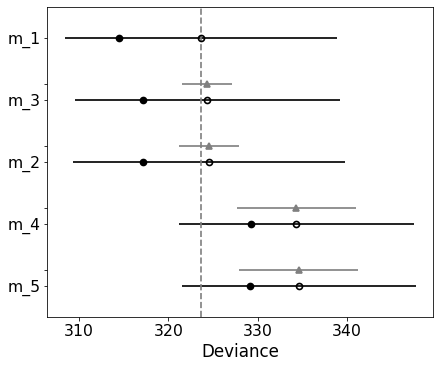

In [20]:
az.plot_compare(compare_m)

As the WAIC comparison returned some warnings let's use the PSIS-LOO method to get another perspective. The values should be almost identical to the ones we had with WAIC.

In [21]:
compare_m = az.compare({"m_1": m_1_trace,"m_2": m_2_trace, 
                        "m_3": m_3_trace,"m_4": m_4_trace, 
                        "m_5": m_5_trace},
                         ic="loo",
                         scale="deviance")
compare_m

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  w

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_1,0,323.683,4.61466,0,0.323136,14.6112,0,False,deviance
m_3,1,324.35,3.58857,0.667046,0.313057,14.458,2.75195,False,deviance
m_2,2,324.533,3.69632,0.850901,0.317547,14.2888,3.33191,False,deviance
m_4,3,334.317,2.52648,10.6349,0.023285,12.8109,6.64186,False,deviance
m_5,4,334.578,2.72944,10.8949,0.0229747,12.7311,6.68819,False,deviance


No warning related to model failure this with PSIS-LOO.
When a point's Pareto k value is above 0.7 PSIS will return a warning, indicating that PSIS's weights are not performing well.
<br>
<br>
For the sake of comparison we can make a scatterplot of *PSIS Pareto k* and *WAIC penalty* to show the relationship between them for each data point in the model. This type of plot is very useful to spot outliers.

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


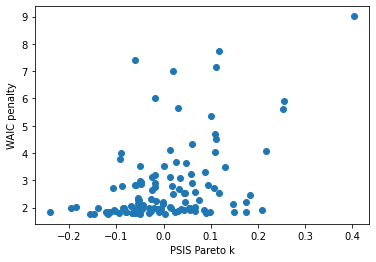

In [22]:
m_1_psis = az.loo(m_1_trace, pointwise=True, scale="deviance")
m_1_waic = az.waic(m_1_trace, pointwise=True, scale="deviance")

plt.scatter(m_1_psis.pareto_k, m_1_waic.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC penalty");

Full PSIS Pareto k diagnostic for model 1:

In [23]:
m_1_loo = az.loo(m_1_trace, pointwise=True, scale="deviance")
m_1_loo

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 8000 by 116 log-likelihood matrix

             Estimate       SE
deviance_loo   323.68    15.25
p_loo            4.61        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      116  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

---

---

In [24]:
%load_ext watermark
%watermark -iv -v -nuw

Last updated: Tue Dec 22 2020

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

scipy     : 1.5.2
numpy     : 1.19.2
pymc3     : 3.9.3
arviz     : 0.10.0
matplotlib: 3.3.2
seaborn   : 0.11.0
pandas    : 1.1.3

Watermark: 2.1.0

